In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import CountVectorizer, IDF, VectorAssembler
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set chart style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")


In [ ]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("TweetAnalysis_TopicModeling") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Available cores: {spark.sparkContext.defaultParallelism}")


In [ ]:
# Load cleaned data and sentiment analysis results
sentiment_data_path = "/home/jovyan/work/data/processed/sentiment_analyzed_comments.parquet"

try:
    df_sentiment = spark.read.parquet(sentiment_data_path)
    df_sentiment.cache()
    record_count = df_sentiment.count()
    print(f"✅ Sentiment analysis data loaded successfully, total {record_count:,} records")
    
    print("\nData structure:")
    df_sentiment.printSchema()
    
    # Check if tokens_cleaned column exists
    if 'tokens_cleaned' in df_sentiment.columns:
        print("\n✅ Found tokens_cleaned column, can proceed directly with topic modeling")
    else:
        print("\n❌ tokens_cleaned column not found, need to re-tokenize")
        
except Exception as e:
    print(f"❌ Data loading failed: {e}")
    print("Trying to load cleaned data...")
    
    # Alternative solution: load cleaned data
    cleaned_data_path = "/home/jovyan/work/data/processed/cleaned_comments.parquet"
    df_sentiment = spark.read.parquet(cleaned_data_path)
    df_sentiment.cache()
    record_count = df_sentiment.count()
    print(f"✅ Cleaned data loaded successfully, total {record_count:,} records")


In [ ]:
# Data preprocessing: filter and prepare topic modeling data
print("=== Data Preprocessing ===")

# 1. Filter out documents with too few tokens (improve topic quality)
df_filtered = df_sentiment.filter(
    F.size(F.col("tokens_cleaned")) >= 5  # at least 5 words
)

filtered_count = df_filtered.count()
print(f"Data size after filtering: {filtered_count:,} records")
print(f"Retention ratio: {filtered_count/record_count*100:.1f}%")

# 2. Further filter Climate Change related keywords to ensure topic relevance
climate_keywords = [
    'climate', 'warming', 'carbon', 'emission', 'greenhouse', 'temperature',
    'fossil', 'renewable', 'energy', 'pollution', 'environment', 'sustainability',
    'weather', 'ice', 'sea', 'level', 'drought', 'flood'
]

# Create filter condition: contains at least one climate-related word
def contains_climate_keywords(tokens):
    if tokens is None:
        return False
    tokens_lower = [token.lower() for token in tokens]
    return any(keyword in tokens_lower for keyword in climate_keywords)

contains_climate_udf = F.udf(contains_climate_keywords, BooleanType())

df_climate = df_filtered.filter(
    contains_climate_udf(F.col("tokens_cleaned"))
)

climate_count = df_climate.count()
print(f"Climate-related comments: {climate_count:,} records")
print(f"Percentage of filtered data: {climate_count/filtered_count*100:.1f}%")

# Cache final data for modeling
df_climate.cache()
print(f"\nFinal data for topic modeling: {climate_count:,} records")


In [ ]:
# Build vocabulary feature vectors
print("=== Building Vocabulary Feature Vectors ===")

# 1. Sample data to reduce memory pressure
print("1. Sampling data to reduce computational burden...")
sample_fraction = 0.3  # Use 30% of data for topic modeling
df_sample = df_climate.sample(fraction=sample_fraction, seed=42)
sample_count = df_sample.count()
print(f"Data size after sampling: {sample_count:,} records ({sample_fraction*100}% of original data)")

# 2. CountVectorizer: Convert tokens to term frequency vectors
# Set smaller vocabulary size and higher minimum word frequency to avoid memory issues
count_vectorizer = CountVectorizer(
    inputCol="tokens_cleaned", 
    outputCol="raw_features",
    vocabSize=2000,  # Reduce vocabulary size
    minDF=10.0       # Increase minimum document frequency
)

print("2. Training CountVectorizer...")
count_model = count_vectorizer.fit(df_sample)
df_vectorized = count_model.transform(df_sample)

# 3. TF-IDF: Calculate word importance weights
idf = IDF(inputCol="raw_features", outputCol="features")
print("3. Training IDF...")
idf_model = idf.fit(df_vectorized)
df_tfidf = idf_model.transform(df_vectorized)

print(f"Vocabulary size: {len(count_model.vocabulary)}")
print(f"Feature vector dimensions: {len(count_model.vocabulary)}")

# Display some example words in vocabulary
print("\nVocabulary examples (first 20 words):")
for i, word in enumerate(count_model.vocabulary[:20]):
    print(f"{i}: {word}")

# Update climate_count to post-sampling count
climate_count = sample_count


In [ ]:
# LDA Topic Modeling
print("=== LDA Topic Modeling ===")

# Set number of topics (reduce number of topics to fit smaller dataset)
NUM_TOPICS = 5  # Reduce number of topics

# Create LDA model
lda = LDA(
    featuresCol="features", 
    topicDistributionCol="topic_distribution",  # 修正：使用正确的参数名
    k=NUM_TOPICS,
    maxIter=10,  # Reduce iteration count to speed up training
    seed=42
)

print(f"Starting LDA model training ({NUM_TOPICS} topics)...")
lda_model = lda.fit(df_tfidf)

print("\n✅ LDA model training completed!")
print(f"Model perplexity: {lda_model.logPerplexity(df_tfidf):.2f}")
print(f"Model log likelihood: {lda_model.logLikelihood(df_tfidf):.2f}")

In [ ]:
# Extract and analyze topic keywords
print("=== Topic Keywords Analysis ===")

# Get keywords for each topic
topics = lda_model.describeTopics(maxTermsPerTopic=15)
vocabulary = count_model.vocabulary

def get_topic_words(topic_data):
    """Convert topic word indices to actual words"""
    topics_list = []
    
    for row in topic_data.collect():
        topic_id = row['topic']
        term_indices = row['termIndices']
        term_weights = row['termWeights']
        
        # Convert indices to words
        words = [vocabulary[idx] for idx in term_indices]
        
        topics_list.append({
            'topic_id': topic_id,
            'words': words,
            'weights': term_weights
        })
    
    return topics_list

topic_words = get_topic_words(topics)

# Display keywords for each topic
print("\n=== Topic Keywords List ===")
for topic in topic_words:
    topic_id = topic['topic_id']
    words = topic['words'][:10]  # Display top 10 keywords
    weights = topic['weights'][:10]
    
    print(f"\n🔍 Topic {topic_id}:")
    for word, weight in zip(words, weights):
        print(f"  {word}: {weight:.4f}")
    
    # Generate topic description (based on keywords)
    key_terms = ", ".join(words[:5])
    print(f"  💡 Key terms: {key_terms}")


In [ ]:
# Assign topics to documents
print("=== Document Topic Assignment ===")

# Transform documents to get topic distribution
df_topics = lda_model.transform(df_tfidf)

# Assign dominant topic for each document (topic with highest probability)
def get_dominant_topic(topic_distribution):
    """Get dominant topic ID"""
    if topic_distribution is None:
        return -1
    return int(np.argmax(topic_distribution.toArray()))

def get_topic_probability(topic_distribution):
    """Get probability of dominant topic"""
    if topic_distribution is None:
        return 0.0
    return float(np.max(topic_distribution.toArray()))

get_dominant_topic_udf = F.udf(get_dominant_topic, IntegerType())
get_topic_prob_udf = F.udf(get_topic_probability, DoubleType())

# Add dominant topic columns
df_topics = df_topics.withColumn(
    "dominant_topic", 
    get_dominant_topic_udf(F.col("topic_distribution"))
).withColumn(
    "topic_probability",
    get_topic_prob_udf(F.col("topic_distribution"))
)

print("✅ Topic assignment completed")

# Display topic distribution statistics
print("\nTopic distribution statistics:")
topic_dist = df_topics.groupBy("dominant_topic").count().orderBy("dominant_topic")
topic_dist.show()

# Convert to Pandas for detailed analysis
topic_dist_pd = topic_dist.toPandas()
total_docs = topic_dist_pd['count'].sum()
topic_dist_pd['percentage'] = (topic_dist_pd['count'] / total_docs * 100).round(2)

print("\nDetailed topic distribution:")
for _, row in topic_dist_pd.iterrows():
    topic_id = int(row['dominant_topic'])
    count = int(row['count'])
    pct = row['percentage']
    
    # Get topic keywords
    if topic_id >= 0 and topic_id < len(topic_words):
        topic_keywords = ", ".join(topic_words[topic_id]['words'][:3])
    else:
        topic_keywords = "undefined"
    
    print(f"Topic {topic_id} ({topic_keywords}): {count:,} documents ({pct}%)")


In [ ]:
# Analyze sentiment distribution for each topic
print("=== Topic Sentiment Analysis ===")

# Check if VADER sentiment scores exist
sentiment_cols = [col for col in df_topics.columns if 'vader' in col.lower() or 
                 col in ['sentiment', 'compound_score', 'pos_score', 'neu_score', 'neg_score']]

print(f"Found sentiment-related columns: {sentiment_cols}")

# Use VADER score if available, otherwise use original sentiment
if 'compound_score' in df_topics.columns:
    sentiment_col = 'compound_score'
    print("Using VADER compound score for sentiment analysis")
elif 'sentiment' in df_topics.columns:
    sentiment_col = 'sentiment'
    print("Using original sentiment score for sentiment analysis")
else:
    print("❌ Sentiment score column not found, skipping sentiment analysis")
    sentiment_col = None

if sentiment_col:
    # Define sentiment classification function
    def classify_sentiment(score):
        if score is None:
            return "Unknown"
        elif score > 0.1:
            return "Positive"
        elif score < -0.1:
            return "Negative"
        else:
            return "Neutral"
    
    classify_sentiment_udf = F.udf(classify_sentiment, StringType())
    
    # Add sentiment classification column
    df_topic_sentiment = df_topics.withColumn(
        "sentiment_label",
        classify_sentiment_udf(F.col(sentiment_col))
    )
    
    # Calculate sentiment distribution for each topic
    topic_sentiment_dist = df_topic_sentiment.groupBy("dominant_topic", "sentiment_label").count().orderBy("dominant_topic", "sentiment_label")
    
    print("\nSentiment distribution for each topic:")
    topic_sentiment_dist.show()
    
    # Convert to pivot table format for analysis
    topic_sentiment_pd = topic_sentiment_dist.toPandas()
    pivot_sentiment = topic_sentiment_pd.pivot(index='dominant_topic', columns='sentiment_label', values='count').fillna(0)
    
    # Calculate proportions
    pivot_sentiment_pct = pivot_sentiment.div(pivot_sentiment.sum(axis=1), axis=0) * 100
    
    print("\nSentiment distribution percentage for each topic (%):")
    print(pivot_sentiment_pct.round(2))
    
    # Analyze sentiment characteristics for each topic
    print("\n=== Topic Sentiment Characteristics Analysis ===")
    for topic_id in range(NUM_TOPICS):
        if topic_id in pivot_sentiment_pct.index:
            row = pivot_sentiment_pct.loc[topic_id]
            pos_pct = row.get('Positive', 0)
            neg_pct = row.get('Negative', 0)
            neu_pct = row.get('Neutral', 0)
            
            # Get topic keywords
            keywords = ", ".join(topic_words[topic_id]['words'][:5])
            
            # Determine topic sentiment tendency
            if pos_pct > neg_pct + 10:
                tendency = "Positive-leaning"
            elif neg_pct > pos_pct + 10:
                tendency = "Negative-leaning"
            else:
                tendency = "Neutral"
            
            print(f"\nTopic {topic_id} ({keywords}):")
            print(f"  Sentiment tendency: {tendency}")
            print(f"  Positive: {pos_pct:.1f}% | Neutral: {neu_pct:.1f}% | Negative: {neg_pct:.1f}%")
            
            # Calculate sentiment polarization degree
            polarization = abs(pos_pct - neg_pct)
            print(f"  Sentiment polarization degree: {polarization:.1f}% ({'High' if polarization > 20 else 'Medium' if polarization > 10 else 'Low'})")


In [ ]:
# Save topic modeling results
print("=== Save Results ===")

# 1. Save data with topic information
output_path = "/home/jovyan/work/data/processed/topic_analyzed_comments.parquet"

# Select columns to save
columns_to_save = [
    "id", "`subreddit.name`", "timestamp", "cleaned_body", 
    "dominant_topic", "topic_probability"
]

# If sentiment analysis results exist, include them
if sentiment_col:
    columns_to_save.extend([sentiment_col, "sentiment_label"])

# Ensure columns exist before saving
available_cols = [col for col in columns_to_save if col in df_topic_sentiment.columns]

df_result = df_topic_sentiment.select(available_cols)
df_result.write.mode("overwrite").parquet(output_path)

print(f"✅ Topic analysis results saved to: {output_path}")
print(f"Saved columns: {len(available_cols)}")
print(f"Saved records: {df_result.count():,}")

# 2. Save topic keywords summary
import json

topic_summary = {
    "model_info": {
        "num_topics": NUM_TOPICS,
        "vocab_size": len(count_model.vocabulary),
        "total_documents": climate_count,
        "log_perplexity": lda_model.logPerplexity(df_tfidf),
        "log_likelihood": lda_model.logLikelihood(df_tfidf)
    },
    "topics": []
}

for topic_id, topic_data in enumerate(topic_words):
    topic_info = {
        "topic_id": topic_id,
        "keywords": topic_data['words'][:10],
        "weights": [float(w) for w in topic_data['weights'][:10]],
        "document_count": int(topic_dist_pd[topic_dist_pd['dominant_topic'] == topic_id]['count'].iloc[0]) if topic_id in topic_dist_pd['dominant_topic'].values else 0
    }
    
    # If sentiment data exists, add sentiment distribution
    if sentiment_col and topic_id in pivot_sentiment_pct.index:
        topic_info["sentiment_distribution"] = {
            "positive": float(pivot_sentiment_pct.loc[topic_id].get('Positive', 0)),
            "neutral": float(pivot_sentiment_pct.loc[topic_id].get('Neutral', 0)),
            "negative": float(pivot_sentiment_pct.loc[topic_id].get('Negative', 0))
        }
    
    topic_summary["topics"].append(topic_info)

# Save topic summary to JSON file
summary_path = "/home/jovyan/work/data/processed/topic_summary.json"
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(topic_summary, f, ensure_ascii=False, indent=2)

print(f"✅ Topic summary saved to: {summary_path}")

print("\n=== LDA Topic Modeling Completed! ===")
print(f"Identified {NUM_TOPICS} topics")
print(f"Processed {climate_count:,} climate-related comments")
print("Topic analysis results are ready for subsequent classification modeling")


=== Topic Visualization and Analysis ===


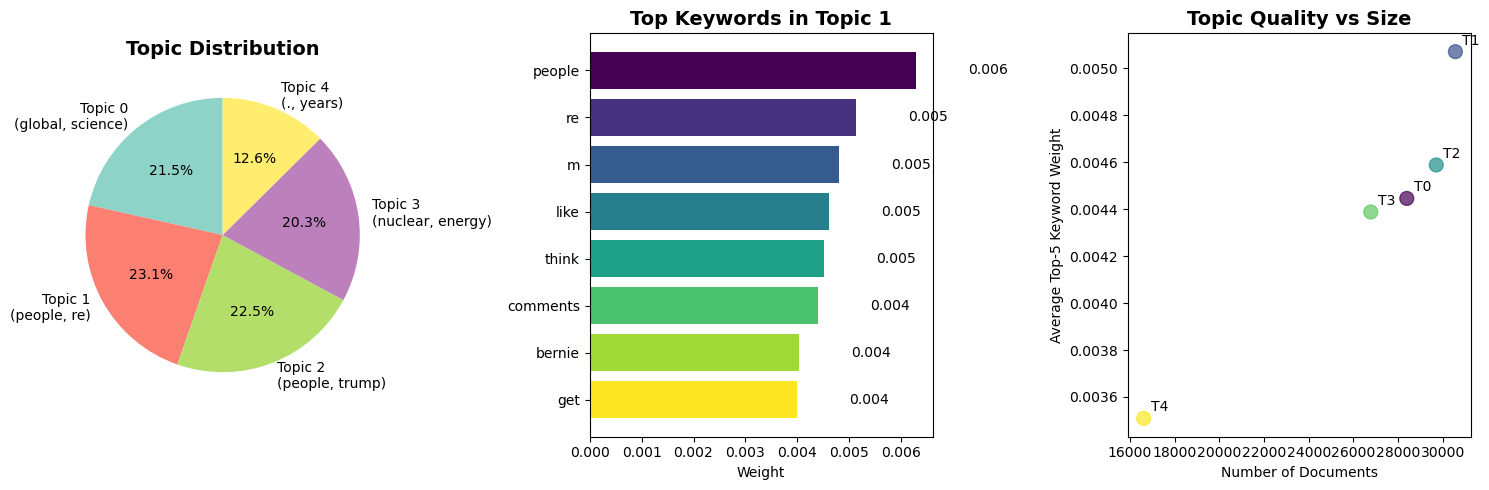


=== Generating Word Clouds for Each Topic ===


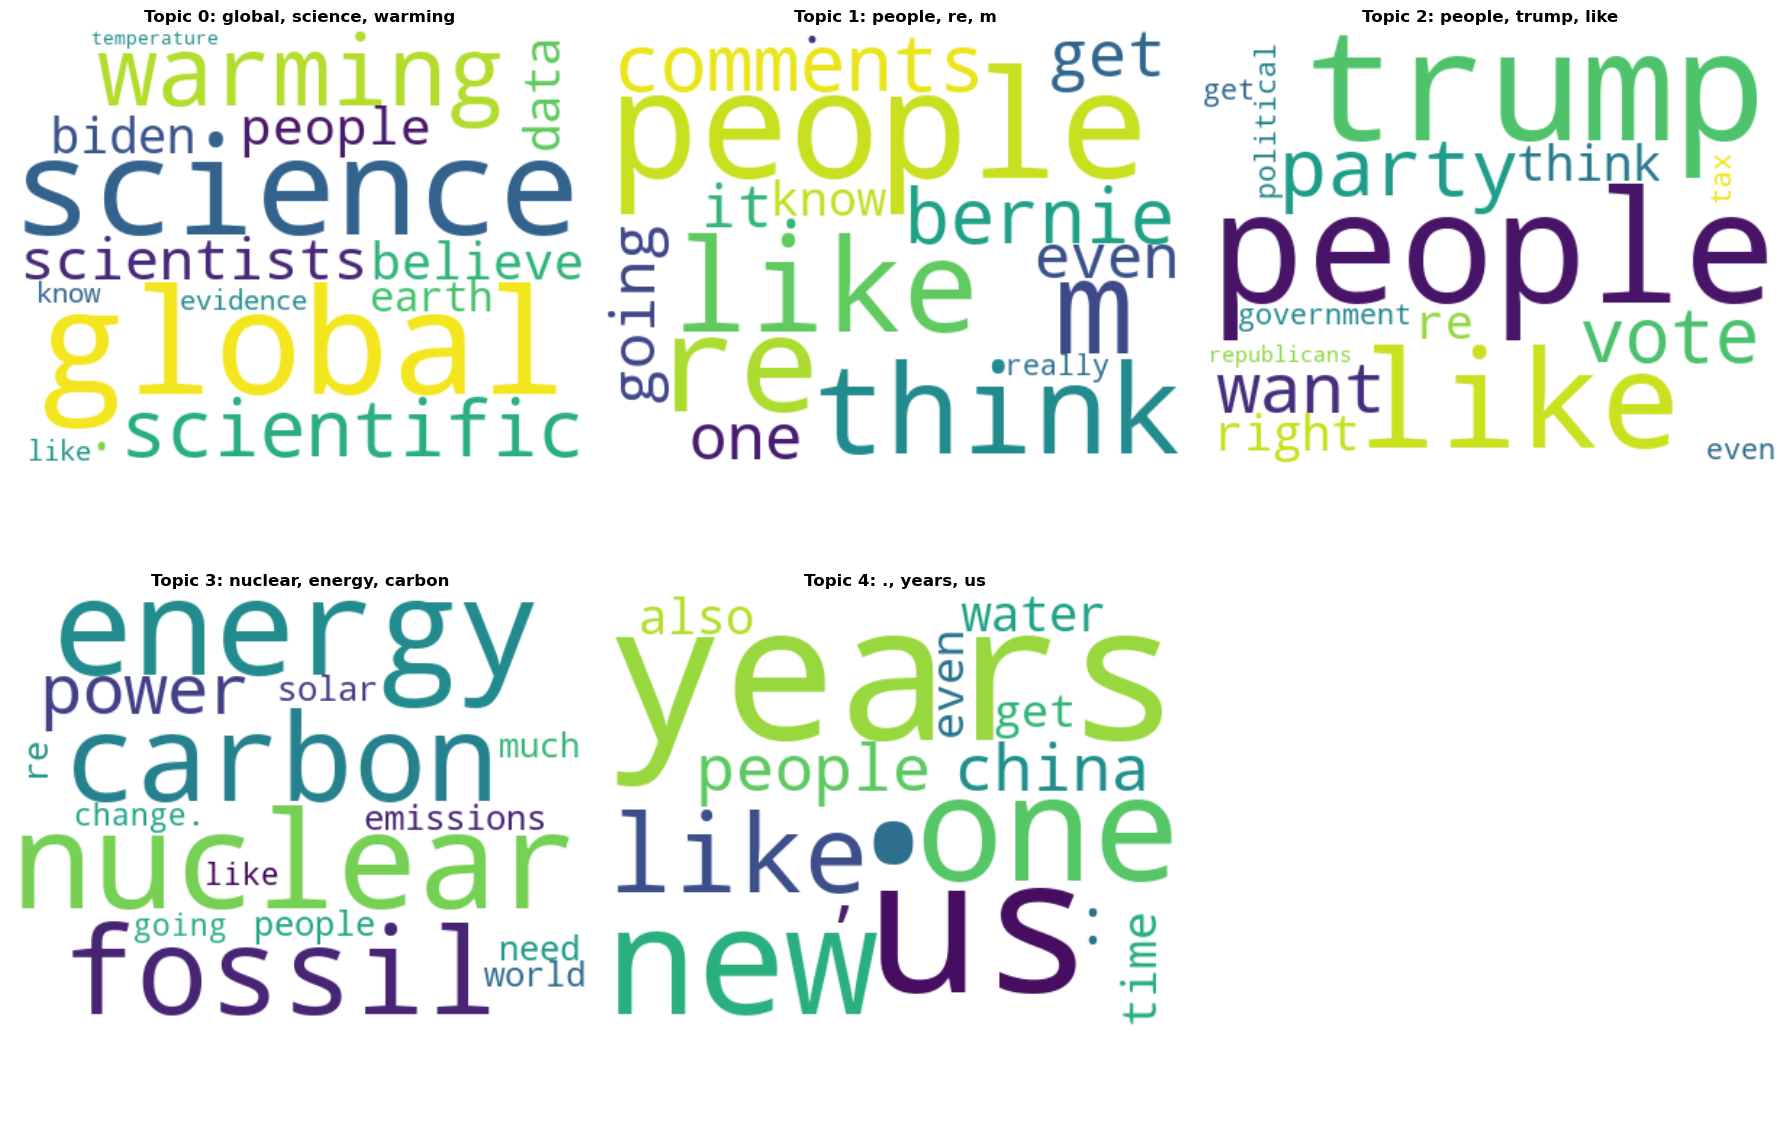


=== Topic Sentiment Visualization ===


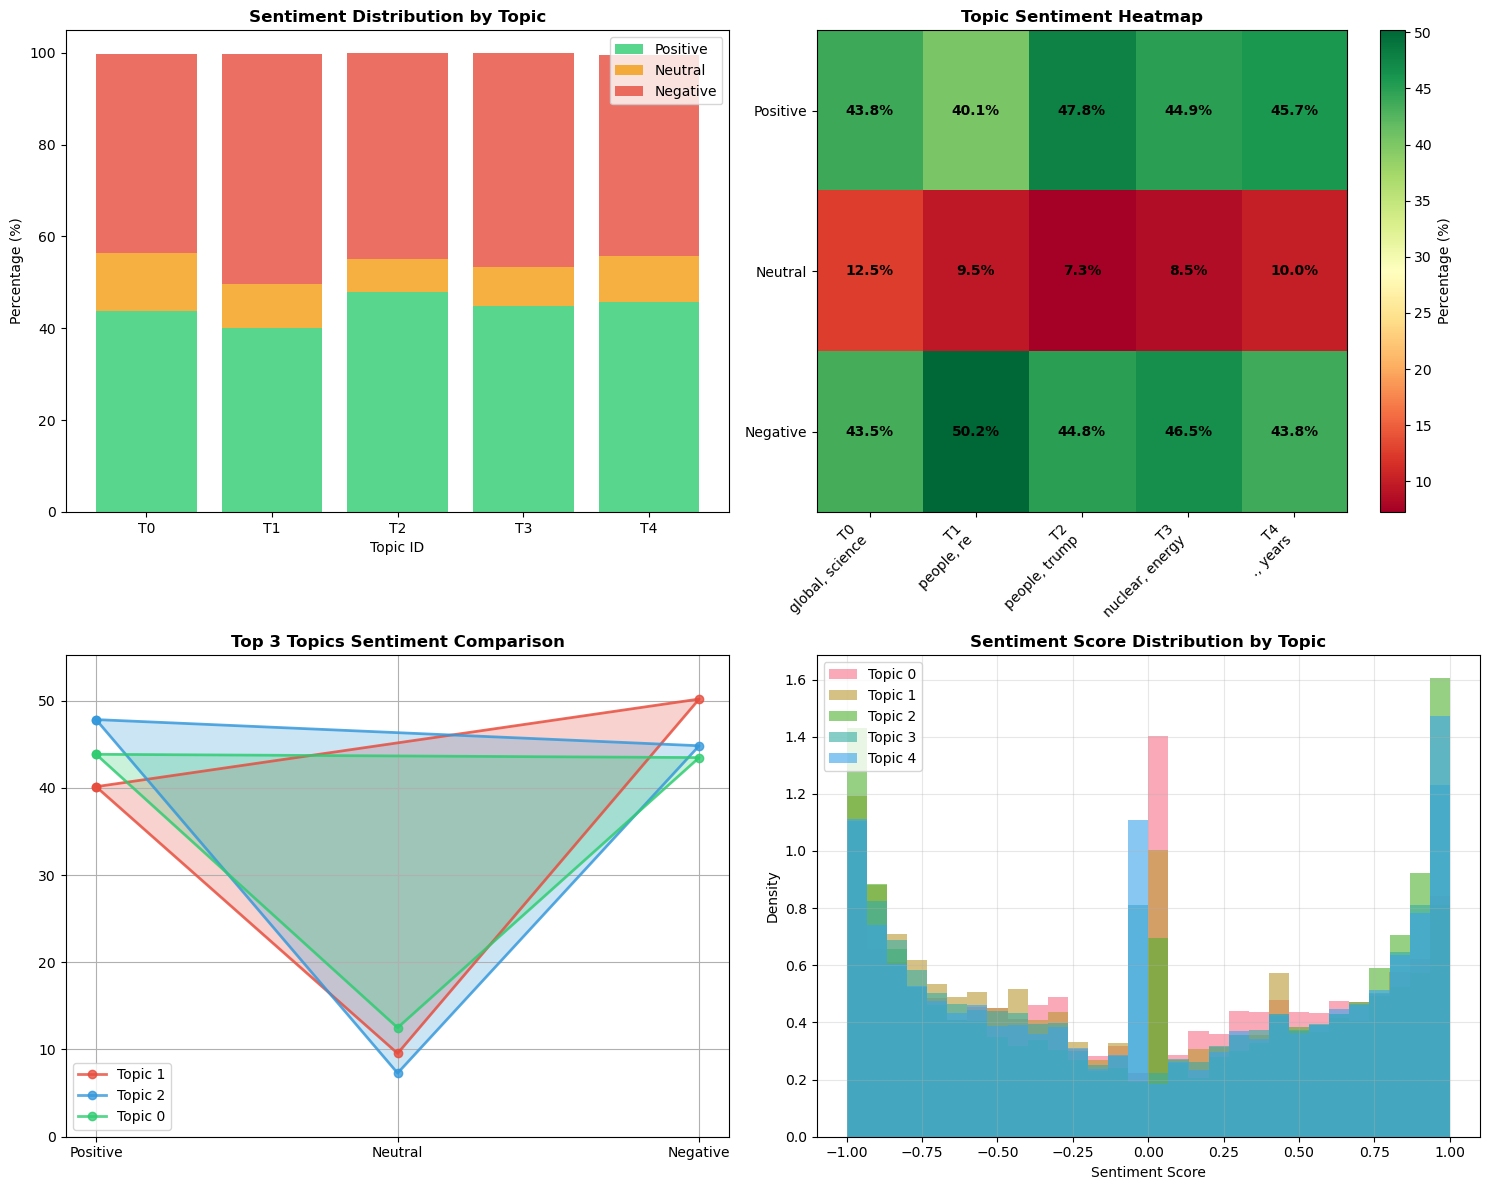


=== Topic Relationships Analysis ===


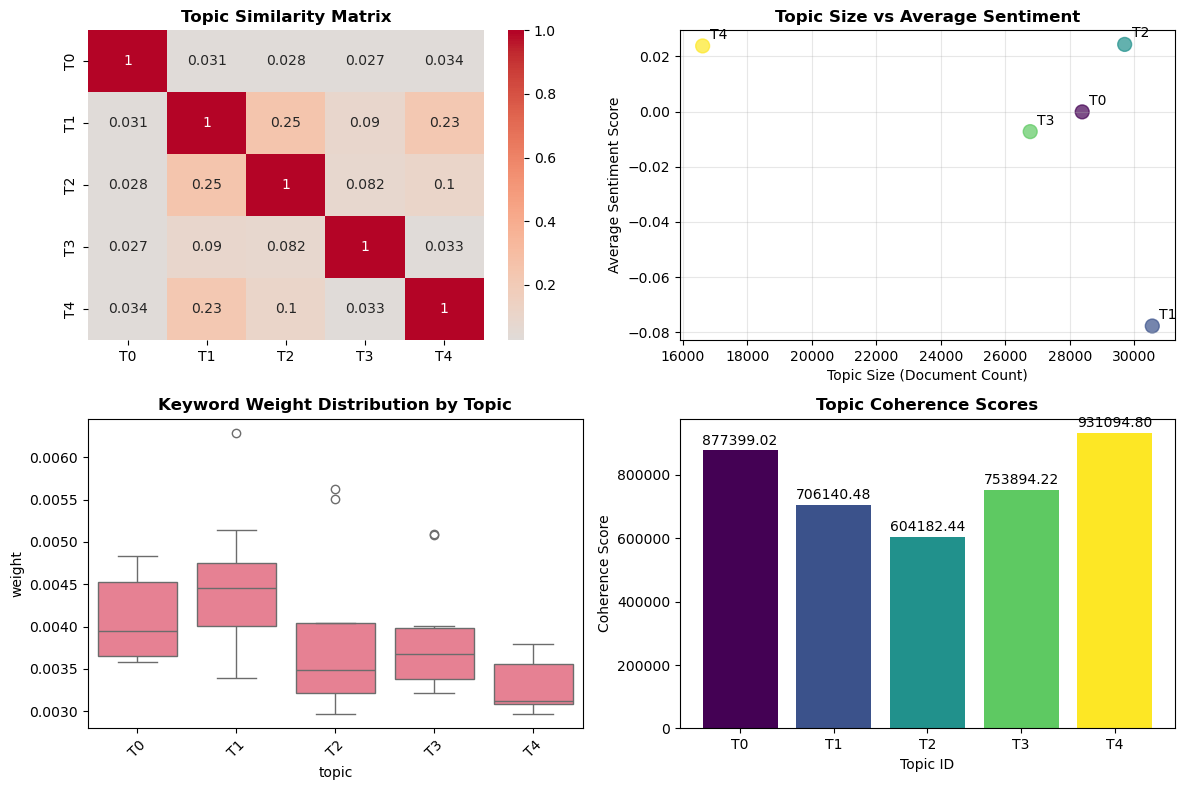


✅ All visualizations generated successfully!
Generated files:
  - topic_distribution_analysis.png
  - topic_wordclouds.png
  - topic_sentiment_analysis.png
  - topic_relationships_analysis.png


In [17]:
# 在现有的 "Save Results" cell 之前添加以下可视化代码

# Topic Visualization and Analysis
print("=== Topic Visualization and Analysis ===")

# 1. Topic Distribution Pie Chart
plt.figure(figsize=(15, 5))

# Create pie chart for topic distribution
plt.subplot(1, 3, 1)
topic_counts = topic_dist_pd['count'].values
topic_labels = [f"Topic {i}\n({', '.join(topic_words[i]['words'][:2])})" 
                for i in topic_dist_pd['dominant_topic'].values]

colors = plt.cm.Set3(np.linspace(0, 1, len(topic_counts)))
plt.pie(topic_counts, labels=topic_labels, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Topic Distribution', fontsize=14, fontweight='bold')

# 2. Topic Keywords Bar Chart
plt.subplot(1, 3, 2)
# Select top topic (highest document count)
top_topic_idx = topic_dist_pd.loc[topic_dist_pd['count'].idxmax(), 'dominant_topic']
top_topic_words = topic_words[top_topic_idx]['words'][:8]
top_topic_weights = topic_words[top_topic_idx]['weights'][:8]

bars = plt.barh(range(len(top_topic_words)), top_topic_weights, 
                color=plt.cm.viridis(np.linspace(0, 1, len(top_topic_words))))
plt.yticks(range(len(top_topic_words)), top_topic_words)
plt.xlabel('Weight')
plt.title(f'Top Keywords in Topic {top_topic_idx}', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels on bars
for i, (bar, weight) in enumerate(zip(bars, top_topic_weights)):
    plt.text(weight + 0.001, i, f'{weight:.3f}', 
             va='center', ha='left', fontsize=10)

# 3. Topic Quality Metrics
plt.subplot(1, 3, 3)
topic_sizes = topic_dist_pd['count'].values
topic_probs = [np.mean([topic_words[i]['weights'][j] for j in range(min(5, len(topic_words[i]['weights'])))]) 
               for i in range(NUM_TOPICS)]

plt.scatter(topic_sizes, topic_probs, s=100, alpha=0.7, 
           c=range(NUM_TOPICS), cmap='viridis')
plt.xlabel('Number of Documents')
plt.ylabel('Average Top-5 Keyword Weight')
plt.title('Topic Quality vs Size', fontsize=14, fontweight='bold')

# Add topic labels
for i, (size, prob) in enumerate(zip(topic_sizes, topic_probs)):
    plt.annotate(f'T{i}', (size, prob), xytext=(5, 5), 
                textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.savefig('/home/jovyan/work/data/processed/topic_distribution_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 4. Word Clouds for Each Topic
print("\n=== Generating Word Clouds for Each Topic ===")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for topic_id in range(NUM_TOPICS):
    words = topic_words[topic_id]['words'][:20]
    weights = topic_words[topic_id]['weights'][:20]
    
    # Create word frequency dictionary
    word_freq = dict(zip(words, weights))
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=400, height=300,
        background_color='white',
        colormap='viridis',
        max_words=20,
        relative_scaling=0.5
    ).generate_from_frequencies(word_freq)
    
    axes[topic_id].imshow(wordcloud, interpolation='bilinear')
    axes[topic_id].set_title(f'Topic {topic_id}: {", ".join(words[:3])}', 
                            fontsize=12, fontweight='bold')
    axes[topic_id].axis('off')

# Hide the last subplot if we have fewer than 6 topics
if NUM_TOPICS < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.savefig('/home/jovyan/work/data/processed/topic_wordclouds.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 5. Sentiment Analysis Visualization (if sentiment data available)
if sentiment_col and 'pivot_sentiment_pct' in locals():
    print("\n=== Topic Sentiment Visualization ===")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 5.1 Stacked Bar Chart for Topic Sentiment Distribution
    ax1 = axes[0, 0]
    sentiment_cols = ['Positive', 'Neutral', 'Negative']
    available_sentiment_cols = [col for col in sentiment_cols if col in pivot_sentiment_pct.columns]
    
    bottom = np.zeros(len(pivot_sentiment_pct))
    colors_sentiment = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red
    
    for i, col in enumerate(available_sentiment_cols):
        if col in pivot_sentiment_pct.columns:
            values = pivot_sentiment_pct[col].values
            ax1.bar(range(len(pivot_sentiment_pct)), values, bottom=bottom, 
                   label=col, color=colors_sentiment[i], alpha=0.8)
            bottom += values
    
    ax1.set_xlabel('Topic ID')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_title('Sentiment Distribution by Topic', fontweight='bold')
    ax1.legend()
    ax1.set_xticks(range(len(pivot_sentiment_pct)))
    ax1.set_xticklabels([f'T{i}' for i in pivot_sentiment_pct.index])
    
    # 5.2 Sentiment Polarization Heatmap
    ax2 = axes[0, 1]
    polarization_data = []
    topic_names = []
    
    for topic_id in range(NUM_TOPICS):
        if topic_id in pivot_sentiment_pct.index:
            row = pivot_sentiment_pct.loc[topic_id]
            pos_pct = row.get('Positive', 0)
            neg_pct = row.get('Negative', 0)
            neu_pct = row.get('Neutral', 0)
            
            polarization_data.append([pos_pct, neu_pct, neg_pct])
            topic_names.append(f"T{topic_id}\n{', '.join(topic_words[topic_id]['words'][:2])}")
    
    polarization_array = np.array(polarization_data)
    im = ax2.imshow(polarization_array.T, cmap='RdYlGn', aspect='auto')
    
    ax2.set_xticks(range(len(topic_names)))
    ax2.set_xticklabels(topic_names, rotation=45, ha='right')
    ax2.set_yticks(range(3))
    ax2.set_yticklabels(['Positive', 'Neutral', 'Negative'])
    ax2.set_title('Topic Sentiment Heatmap', fontweight='bold')
    
    # Add text annotations
    for i in range(len(topic_names)):
        for j in range(3):
            text = ax2.text(i, j, f'{polarization_array[i, j]:.1f}%',
                           ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax2, label='Percentage (%)')
    
    # 5.3 Topic Sentiment Radar Chart (for top 3 topics)
    ax3 = axes[1, 0]
    top_3_topics = topic_dist_pd.nlargest(3, 'count')['dominant_topic'].values
    
    angles = np.linspace(0, 2 * np.pi, len(available_sentiment_cols), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    colors_radar = ['#e74c3c', '#3498db', '#2ecc71']
    
    for i, topic_id in enumerate(top_3_topics):
        if topic_id in pivot_sentiment_pct.index:
            values = [pivot_sentiment_pct.loc[topic_id].get(col, 0) for col in available_sentiment_cols]
            values += values[:1]  # Complete the circle
            
            ax3.plot(angles, values, 'o-', linewidth=2, label=f'Topic {topic_id}', 
                    color=colors_radar[i], alpha=0.8)
            ax3.fill(angles, values, alpha=0.25, color=colors_radar[i])
    
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(available_sentiment_cols)
    ax3.set_ylim(0, max(pivot_sentiment_pct.max()) * 1.1)
    ax3.set_title('Top 3 Topics Sentiment Comparison', fontweight='bold')
    ax3.legend()
    ax3.grid(True)
    
    # 5.4 Sentiment Score Distribution
    ax4 = axes[1, 1]
    
    # Get sentiment scores for each topic
    topic_sentiment_scores = []
    for topic_id in range(NUM_TOPICS):
        topic_scores = df_topic_sentiment.filter(
            F.col("dominant_topic") == topic_id
        ).select(sentiment_col).toPandas()[sentiment_col].dropna()
        
        if len(topic_scores) > 0:
            ax4.hist(topic_scores, bins=30, alpha=0.6, 
                    label=f'Topic {topic_id}', density=True)
    
    ax4.set_xlabel('Sentiment Score')
    ax4.set_ylabel('Density')
    ax4.set_title('Sentiment Score Distribution by Topic', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/home/jovyan/work/data/processed/topic_sentiment_analysis.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# 6. Topic Evolution and Relationships
print("\n=== Topic Relationships Analysis ===")

plt.figure(figsize=(12, 8))

# Calculate topic similarity based on keyword overlap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Create documents from topic keywords
topic_docs = []
for topic in topic_words:
    topic_docs.append(' '.join(topic['words'][:10]))

# Calculate TF-IDF for topic keywords
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(topic_docs)
similarity_matrix = cosine_similarity(tfidf_matrix)

# Create similarity heatmap
plt.subplot(2, 2, 1)
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', center=0,
            xticklabels=[f'T{i}' for i in range(NUM_TOPICS)],
            yticklabels=[f'T{i}' for i in range(NUM_TOPICS)])
plt.title('Topic Similarity Matrix', fontweight='bold')

# Topic size vs average sentiment (if available)
if sentiment_col:
    plt.subplot(2, 2, 2)
    topic_avg_sentiment = []
    topic_sizes = []
    
    for topic_id in range(NUM_TOPICS):
        topic_sentiment_data = df_topic_sentiment.filter(
            F.col("dominant_topic") == topic_id
        ).select(sentiment_col).toPandas()[sentiment_col].dropna()
        
        if len(topic_sentiment_data) > 0:
            avg_sentiment = topic_sentiment_data.mean()
            topic_avg_sentiment.append(avg_sentiment)
            topic_sizes.append(topic_dist_pd[topic_dist_pd['dominant_topic'] == topic_id]['count'].iloc[0])
    
    scatter = plt.scatter(topic_sizes, topic_avg_sentiment, 
                         s=100, alpha=0.7, c=range(len(topic_sizes)), cmap='viridis')
    
    for i, (size, sentiment) in enumerate(zip(topic_sizes, topic_avg_sentiment)):
        plt.annotate(f'T{i}', (size, sentiment), xytext=(5, 5), 
                    textcoords='offset points', fontsize=10)
    
    plt.xlabel('Topic Size (Document Count)')
    plt.ylabel('Average Sentiment Score')
    plt.title('Topic Size vs Average Sentiment', fontweight='bold')
    plt.grid(True, alpha=0.3)

# Topic keyword weights distribution
plt.subplot(2, 2, 3)
all_weights = []
topic_labels = []

for topic_id, topic in enumerate(topic_words):
    weights = topic['weights'][:10]
    all_weights.extend(weights)
    topic_labels.extend([f'T{topic_id}'] * len(weights))

df_weights = pd.DataFrame({'weight': all_weights, 'topic': topic_labels})
sns.boxplot(data=df_weights, x='topic', y='weight')
plt.title('Keyword Weight Distribution by Topic', fontweight='bold')
plt.xticks(rotation=45)

# Topic coherence visualization
plt.subplot(2, 2, 4)
topic_coherence = []
for topic in topic_words:
    # Simple coherence measure: variance of top keyword weights
    top_weights = topic['weights'][:5]
    coherence = 1 / (np.var(top_weights) + 1e-6)  # Higher coherence = lower variance
    topic_coherence.append(coherence)

bars = plt.bar(range(NUM_TOPICS), topic_coherence, 
               color=plt.cm.viridis(np.linspace(0, 1, NUM_TOPICS)))
plt.xlabel('Topic ID')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence Scores', fontweight='bold')
plt.xticks(range(NUM_TOPICS), [f'T{i}' for i in range(NUM_TOPICS)])

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, topic_coherence)):
    plt.text(i, score + max(topic_coherence)*0.01, f'{score:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('/home/jovyan/work/data/processed/topic_relationships_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ All visualizations generated successfully!")
print("Generated files:")
print("  - topic_distribution_analysis.png")
print("  - topic_wordclouds.png")
if sentiment_col:
    print("  - topic_sentiment_analysis.png")
print("  - topic_relationships_analysis.png")